### Trial Distances by dimension type
- Have a suspiscion that High X within-dim trials are closer together, which would make them more affected by nonsense correlations, providing an explanation for why decoder weights are closer together

### Per pair, per session in pair, find High X for feat1, feat2, compute num trials distance between feats

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.io_utils as io_utils
import os
from distutils.util import strtobool

import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from constants.behavioral_constants import *

from scipy import stats


In [2]:
sub = "SA"
SESSIONS_PATH = "/data/patrick_res/sessions/{sub}/valid_sessions.pickle"
SA_MORE_SESS_PAIRS_PATH = "/data/patrick_res/sessions/SA/pairs_at_least_3blocks_10sess_more_sess.pickle"

valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
pairs = pd.read_pickle(SA_MORE_SESS_PAIRS_PATH)

In [15]:
def get_high_x_trials(beh, feat):
    beh = behavioral_utils.get_feat_choice_label(beh, feat)
    beh = behavioral_utils.filter_behavior(beh, {"Response": "Correct", "Choice": "Chose"})
    beh = behavioral_utils.get_belief_partitions_by_mode(beh, feat, "pref")
    beh = beh[beh["PartitionLabel"] == "High X"]
    return beh

def process_session(session, pair):
    feat1, feat2 = pair
    beh = behavioral_utils.get_valid_belief_beh_for_sub_sess("SA", session)
    feat1_beh = get_high_x_trials(beh, feat1)
    feat2_beh = get_high_x_trials(beh, feat2)
    cross = pd.merge(feat1_beh, feat2_beh, how="cross")
    dist = np.abs(cross.TrialNumber_x - cross.TrialNumber_y)
    return pd.DataFrame({"dist": dist})


def process_pair(row):
    res = []
    for session in row.sessions:
        res.append(process_session(session, row.pair))
    res = pd.concat(res)
    res["dim_type"] = row.dim_type
    return res

In [18]:
tqdm.pandas()
res = pd.concat(pairs.progress_apply(process_pair, axis=1).values)

100%|██████████| 17/17 [00:25<00:00,  1.50s/it]


Text(0.5, 0, "Num trials between High X's for pairs of features")

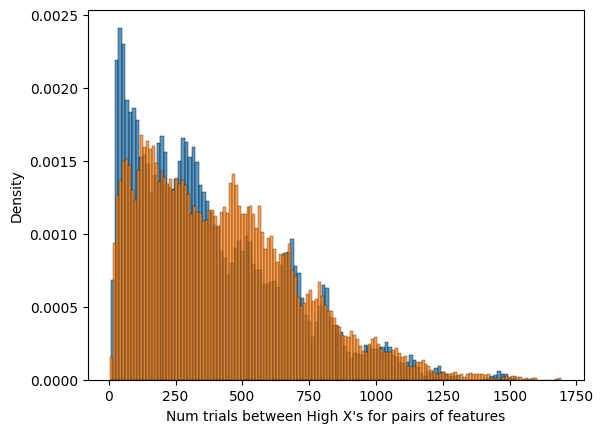

In [26]:
fig, ax = plt.subplots()
sns.histplot(res[res.dim_type == "within dim"], x="dist", stat="density", ax=ax)
sns.histplot(res[res.dim_type == "across dim"], x="dist", stat="density", ax=ax)

ax.set_xlabel("Num trials between High X's for pairs of features")